# Notebook 4: COMPAS Case Study of Algorithmic Fairness

In this notebook, we'll take a look at questions of fairness in algorithmic decision making and risk assessment systems as we analyze COMPAS—a commercial tool used to inform sentencing by predicting an individual's risk of recidivism (the likelihood that a convicted person will commit another crime) on a scale of 1-10. 

COMPAS is <i>the</i> case study of recidivism risk-scoring algorithms. Understanding COMPAS and the conversation around it is essential knowledge for justice-oriented data thinkers like ourselves. **If you aren't already familiar with COMPAS, take a moment to read [ProPublica's "Machine Bias;"](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) which was a recommended reading in week nine.**

### Learning Objectives
* Identify and explain how algorithms exist as technologies that interact with humans in social institutions, often in nontrivial ways.
* Recognize that fairness is a socially-defined and dynamic idea.
* Understand how definitions of fairness can be used to evaluate algorithms and come to distinct conclusions.
* Recognize the limitations of technical solutions to algorithmic bias with social consequences.

### Table of Contents
1. Understanding COMPAS
2. The Debate about COMPAS<br>
    a. ProPublica's perspective<br>
    b. equivant's perspective
3. ProPublica's Analysis
4. equivant's Analysis
5. Conclusion


Before we begin, run the cell below to install necessary dependencies.

In [2]:
# Just run this cell
import numpy as np # Loads numerical methods
import pandas as pd # This allows us to transform our data into tables (AKA DataFrames) 

from sklearn.metrics import roc_curve, roc_auc_score # Loads visualization tools for a ROC Curve
import matplotlib.pyplot as plt # Loads more visualization tools
import seaborn as sns # Loads more visualization tools

import otter
generator = otter.Notebook()

## 1. Understanding COMPAS

### What is COMPAS?
COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a commercial tool originally produced by the for-profit company Northpointe, that has since been acquired by the also for-profit [equivant](https://www.equivant.com). We will refer to the company behind COMPAS as equivant, but conversations you encounter online may have been written before the acquistion, and still refer to Northpointe (such as the ProPublica article).

Decision making within the US criminal justice system relies heavily on risk assessment, especially in conversations of pre-trial detainment and recidivism. Risk has become the language with which a judge or parole board formulates and justifies their decision to set bail, grant parole, and determine sentencing, based on their beliefs of the likelihood that a defendant will fail to appear in court, commit another crime, or pose a threat to the public. While the concept of labeling defendants as more or less "risky," isn't new in the justice system, the use of risk scores determined by algorithms to inform these labels is gaining traction.

COMPAS was originally designed to aid decisions made by probation officers on treatment and supervision of incarcerated people, but it and other risk-scoring algorithms are being used to inform decisions about freedom at numerous points throughout the criminal justice system. It does this by producing a risk score from 1 (lowest) to 10 (highest) based on the model's prediction of the likelihood a defendant will commit a future crime.

#### Language Matters
In this conversation, we deal with terms like **model**, **algorithm**, **bias**, and **risk**. These terms often have different definitions and implications in data science contexts than they do in our daily conversations.

In data science and machine learning, COMPAS is what we refer to as a **model**. A model is composed of a dataset that has **features** (the columns in a table that categorize its data) and an **algorithm**—a procedure that makes a prediction about unknown values based on patterns found in the data. 

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 1a:</b> How do you use the term "algorithm" in your daily life? Is it different than the way it is used in technical conversations?
</div>

<!--
BEGIN QUESTION
name: q1a
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

<!-- END QUESTION -->

Similarly, in data science, **risk** and **bias** are terms used to describe how well a model performs the task it was designed for. **Risk functions** quantify how accurate a model's predictions are, and help us reduce error. Bias is a type of error that describes model inaccuracy as a result of our model systematically misrepresenting the real world phenomena it is designed to capture and can be minimized using better math and engineering. This is a different way of thinking about bias than we are used to in conversations about society, discrimination, and injustice.
    
<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 1b:</b> How is the term bias used in conversations about technology and justice systems? Is it used differently in conversations about data science and machine learning?
</div>
 
<!--
BEGIN QUESTION
name: q1b
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

<!-- END QUESTION -->

In the real world, bias, as it is communly used, cannot be eliminated or solved for. For that reason, its sometimes more helpful to think of bias as **perspective** in conversations about justice. Doing so can remind us that the lens with which we view the world, informed by our position within it, inevitably distorts what we see and the conclusions we draw about it. Our perspectives are unique and everpresent, and cannot be solved away or minimized like we might treat a bias term in a data science context.
    
<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 1c:</b> Identify three parties that are impacted by COMPAS. How are they impacted? Can you think of at least one example of impacts beyond the scope of the courtroom?
</div>
 
<!--
BEGIN QUESTION
name: q1c
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

<!-- END QUESTION -->

#### How COMPAS works
Before COMPAS can create a risk score for a defendant, they are asked to fill out a questionnaire. Let's take a look at this questionnaire to get a better understanding of what goes into determining a risk score.

Take a look at [this sample questionnaire](https://www.documentcloud.org/documents/2702103-Sample-Risk-Assessment-COMPAS-CORE.html), used by COMPAS.

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 1d:</b> What aspects of the questionnaire were particularly striking to you?
</div>

<!--
BEGIN QUESTION
name: q1d
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 1e:</b> Which stories about criminality and justice does this questionairre reinforce or reinvent? Are those stories different than the ones you are used to hearing? Identify one or more readings we've done in this class that can help you understand the relationship between COMPAS and stories of criminality.
</div>

<!--
BEGIN QUESTION
name: q1e
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

## 2. The Debate about COMPAS

Proponents of COMPAS and other risk-assessment tools argue that risk scores help judges make more accurate, consistent, and informed decisions. Algorithms are often seen as evening out the emotions and imperfections that pervade human judgement ([Henry](https://theappeal.org/risk-assessment-explained/)). Opponents disagree, shedding doubt on the algorithm's accuracy and criticizing its potential to exacerbate discrimination in courtrooms.

For the rest of the notebook, we'll replicate the analyses used by equivant and ProPublica to understand how competing definitions of fairness can be mathematically incompatible.

#### What is ProPublica?
ProPublica is a nonprofit organization that, according to their website, "produces investigative journalism with moral force” ([ProPublica](https://www.propublica.org/about/)). ProPublica was founded as a nonpartisan newsroom aiming to expose and question abuses of power, justice, and public trust, often by systems and institutions deeply ingrained in the US.

In 2016, ProPublica investigated the COMPAS algorithm to assess its accuracy and guage the potential of racial bias within the tool. In their analysis, ProPublica used data from defendants given risk scores from Broward County, Florida from 2013 and 2014 to test for statistical differences in outcomes for Black and white defendants. ProPublica came to the conclusion that COMPAS treats Black defendants unfairly because the model "was particularly likely to falsely flag black defendants as future criminals, wrongly labeling them this way at almost twice the rate as white defendants" ([ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)). ProPublica claimed that this was a result of the model utilizing data from a criminal justice system with a history of racial injustices, thus continuing to disproportionately target and arrest Black people in comparison to their white counterparts. 

#### What is equivant?

equivant (then Northpointe) refuted the claim that COMPAS treated Black defendants unfairly. Northpointe was a for-profit computer software company that aimed to advance justice by informing and instilling confidence in decision makers at every stage of the criminal justice system ([equivant](https://www.equivant.com/)).  In addition to operating and continuing to develop COMPAS, equivant has developed a variety of technologies for use in court case management, attorney case management, inmate classification, and risk/needs assessment strategies.  

In the wake of criticism from ProPublica and other researchers, equivant produced a [detailed response](http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf) to ProPublica’s allegations, claiming that these critiques of their tool utilized the wrong type of classification statistics in their analysis and portrayed the tool incorrectly. The company provided their own analysis of the COMPAS algorithm by using different statistical methods and responding individually to each of ProPublica’s claims of racial bias against Black defendants. 

Upon examining their tool’s fairness through "*accuracy equity*" (a metric coined by equivant that was left out of ProPublica’s analysis), as well as the fact that the model was not trained with a race feature, equivant concluded that their algorithm treats all people and specified groups equally, and therefore does not exhibit signs of bias or inequality for specified groups.

#### Competing definitions of fairness

ProPublica claimed that COMPAS was unfair for Black defendants because it falsely predicted that Black defendants would commit future crimes at nearly twice the rate that it made the same error for white defendants. Put another way, ProPublica argued that an algorithm cannot be fair if it makes errors in predicting recidivism rates for one racial group more frequently than another.

equivant claimed that COMPAS *was* fair because Black and white defendants were discriminated against equally—the score outputted corresponded to the same outcomes irrespective of race. They pointed to data that showed Black defendants and white defendants, assigned the same risk score, went on to commit future crimes at nearly the same rates.

In what follows, we'll retrace both ProPublica and equivant's statistical analysis in order to better understand their arguments and the metrics of fairness they use. By the time we're done, we'll have demonstrated that definitions of fairness can be internally sound, but mathematically incompatible with each other.

## 3. ProPublica's Analysis
### Disproportionate risk scores
To understand why ProPublica found COMPAS to be unfair, we'll look at the same data they used to conduct their analysis—a collection of public records containing people assigned risk scores from 2013 and 2014 in Broward County, Florida ([ProPublica](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)).

In [31]:
# Run this cell to load the data used by ProPublica
propublica_data = pd.read_csv("data/compas-scores-two-years.csv")
propublica_data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


ProPublica explains some of the process by which they filtered the data, stating, "It was not always clear, however, which criminal case was associated with an individual’s COMPAS score. To match COMPAS scores with accompanying cases, we considered cases with arrest dates or charge dates within 30 days of a COMPAS assessment being conducted. In some instances, we could not find any corresponding charges to COMPAS scores. We removed those cases from our analysis" ([ProPublica](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)). 

In the cell below, we do the same filtering, and narrow down the features of the dataset to those relevant to ProPublica's analysis.

In [32]:
# Just run this cell
propublica_data = propublica_data.query('days_b_screening_arrest <= 30 & days_b_screening_arrest >= -30')

propublica_data = propublica_data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
                    "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid"]]
propublica_data

,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid
0,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1
2,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1
5,44,M,Other,25 - 45,Low,Male,0,0.0,1,0,0
6,41,F,Caucasian,25 - 45,Medium,Male,14,-1.0,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7209,23,F,African-American,Less than 25,Medium,Male,0,-1.0,7,0,0
7210,23,F,African-American,Less than 25,Low,Male,0,-1.0,3,0,0
7211,57,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
7212,33,M,African-American,25 - 45,Low,Female,3,-1.0,2,0,0


<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 3a:</b> Explore the dataset. What does a row in the dataset represent? 
</div>

<!--
BEGIN QUESTION
name: q3a
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

<!-- END QUESTION -->

#### Visualizing risk scores
Let's visualize how ProPublica began their investigation of racial disparity within the COMPAS risk assessment. The histogram below displays the differences between risk scores (the 'decile_score' feature in the data above) assigned to Black and white defendants.

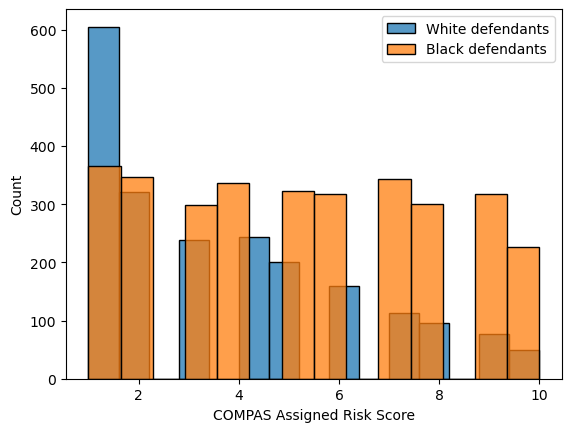

In [30]:
# Run this cell
white_defendant_scores = propublica_data[propublica_data["race"] == "Caucasian"]
sns.histplot(white_defendant_scores["decile_score"], label="White defendants")

black_defendant_scores = propublica_data[propublica_data["race"] == "African-American"]
sns.histplot(black_defendant_scores["decile_score"], label="Black defendants"); 

plt.xlabel("COMPAS Assigned Risk Score")
plt.legend()
plt.show()

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 3b:</b> Examine the visualization above. Is one racial group more likely to recieve higher or lower risk scores than the other? Explain how you know.
</div>

<!--
BEGIN QUESTION
name: q3b
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

<!-- END QUESTION -->

### False Positive and False Negative Rates

In order to understand the ways in which bias is present in COMPAS's assigned risk scores, ProPublica used the **False Positive Rate (FPR)** and **False Negative Rate (FNR)** as their metrics to understand and quantify fairness. Recall that models use algorithms to predict a target feature (in this case the likelihood of recidivism). We can evaluate how well a model predicts these features by using metrics like **false positive** and **false negative** rates (as well as their counterparts, true positive and true negative rates).

A false positive occurs when a model incorrectly predicts an positive outcome. For instance, testing positive for COVID-19 when you don't actually have the virus. A false negative follows similar logic, occuring when a model incorrectly predicts a negative outcomes. For instance, testing negative for COVID-19 when you do infact have the virus.

It's important to remember that the cost of false positives and false negatives isn't usually the same. To extend the COVID-19 example, it is perhaps favorable to design a test that has a higher false positive rate in exchange for a lower false negative rate. Falsely testing positive for COVID-19 usually results in an individual taking another test or going to the doctor to confirm the first test. Falsely testing negative for COVID-19, on the other hand, could have more serious ramifications if the individual goes on to expose others to the virus unknowingly.

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 3c:</b> Remember that the goal of COMPAS is to predict whether or not a defendant will commit a future crime. In the context of COMPAS, what would a false positive be? What would a false negative be?
</div>

<!--
BEGIN QUESTION
name: q3c
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

<!-- END QUESTION -->

Below, we define functions to calculate the false positive and false negative rates based on the data from ProPublica. In the data, the 'two_year_recid' feature contains a 0 if the individual did not commit another crime in two years since they were assigned a risk score, and a 1 otherwise. COMPAS predicts that a defendant will commit a future crime if they receive a risk score greater than or equal to 4. As such, a false positive occurs when a defendant receieves a 'decile_score' of 4 or greater, but has a 'two_year_recid' value of 0.

In [55]:
def fpr(race_feature, data):
    # Function returns the False Positive Rate of scores for the specified race_feature
    
    subgroup = data[data["race"] == race_feature]
    did_not_recidivate = subgroup[subgroup["two_year_recid"] == 0]

    false_positives = did_not_recidivate[did_not_recidivate["decile_score"] > 4].shape[0]
    true_negatives = did_not_recidivate[did_not_recidivate["decile_score"] <= 4].shape[0]
    return false_positives / (false_positives + true_negatives)


def fnr(race_feature, data):
    # Function returns the False Negative Rate of scores for the specified race_feature
    
    subgroup = data[data["race"] == race_feature]
    recidivated = subgroup[subgroup["two_year_recid"] == 1]
    
    false_negatives = recidivated[recidivated["decile_score"] <= 4].shape[0]
    true_positives = recidivated[recidivated["decile_score"] > 4].shape[0]
    return false_negatives / (false_negatives + true_positives)

In [57]:
# Apply the metrics to the dataset
black_defendant_fpr = round(fpr("African-American", propublica_data), 5) * 100
white_defendant_fpr = round(fpr("Caucasian", propublica_data), 5) * 100
black_defendant_fnr = round(fnr("African-American", propublica_data), 4) * 100
white_defendant_fnr = round(fnr("Caucasian", propublica_data), 5) * 100

print("FPR for Black defendants:", black_defendant_fpr, "%")
print("FPR for white defendants:", white_defendant_fpr, "%")
print("FNR for Black defendants:", black_defendant_fnr, "%")
print("FNR for white defendants:", white_defendant_fnr, "%")

FPR for Black defendants: 42.338 %
FPR for white defendants: 22.014 %
FNR for Black defendants: 28.48 %
FNR for white defendants: 49.635 %


<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 3d:</b> What do you notice about these percentages? Is COMPAS making incorrect predictions for one racial group more than the other? Which kinds of predictions?
</div>

<!--
BEGIN QUESTION
name: q3d
points: 1
manual: true
-->

**Answer:** *Double-click to edit with your answer*

<!-- END QUESTION -->

...

## 4. equivant's Analysis

...


## 5. Conclusion



<!-- BEGIN QUESTION -->

<div class="alert alert-block alert-info">
<b>Labor Question:</b> How much time did you spend completing this module? Did you find outside resources that helped you? if so what were they?
</div>


<!--
BEGIN QUESTION
name: QL
points: 1
manual: true
-->

# Save your notebook first, then go to `Kernel` > `Restart and Run All Cells`
# Download the zip file, which contains a copy of your notebook and your written responses.
generator.export("notebook4.ipynb")